In [1]:
import random
import sys
import numpy as np
import csv
import math
from collections import defaultdict
from collections import OrderedDict
import matplotlib.pyplot as plt

In [2]:
class game():
    def __init__(self, suits = 4):
        self.agentHand = defaultdict(int)
        self.compHand = defaultdict(int)
        self.book = defaultdict(int)
        self.count = 0
        for i in range(1,14):
            self.agentHand[i] = 0
            self.compHand[i] = 0
            self.book[i] = 0
        self.suits = suits
        self.deck = list(range(1,14)) * self.suits # cards as 1-13, a=1, j=11, etc
        random.shuffle(self.deck)
        self.score = [0,0] #agent score, computer score
        self.stepCount = 0 # debug
        self.deal()
        #self.debug()
        return
        
    def emptyDeck(self):
        return len(self.deck) == 0
        
    def agentDraw(self):
        if self.emptyDeck():
            return
        card = self.deck.pop(0)
        self.agentHand[card] += 1
        return card
        
    def compDraw(self):
        if self.emptyDeck():
            return
        card = self.deck.pop(0)
        self.compHand[card] += 1
        return card
        
    def agentHas(self, card): # check if agent has card
        return self.agentHand[card] != 0
    
    def compHas(self, card): # check if agent has card
        return self.compHand[card] != 0
        
    def agentSteal(self, card): # agent take computer card
        #print("steal", self.compHand[card])
        self.agentHand[card] += self.compHand[card]
        self.compHand[card] = 0
        #print(self.agentHand[card],self.compHand[card])
        return
        
    def compSteal(self, card): # computer take agent card
        self.compHand[card] += self.agentHand[card]
        self.agentHand[card] = 0
        return
        
    def agentBook(self, card): # check if agent scores
        if self.agentHand[card] == 4:
            self.book[card] += 1
            self.agentHand[card] = 0
            self.score[0] += 1
            return True
        return False
    
    def compBook(self, card): # check if computer scores
        if self.compHand[card] == 4:
            self.book[card] += 1
            self.compHand[card] = 0
            self.score[1] += 1
            return True
        return False
            
    def agentEmpty(self):
        return sum(self.agentHand.values()) == 0
    
    def compEmpty(self):
        return sum(self.compHand.values()) == 0
    
    def gameOver(self):
        return sum(self.score) == 13
    
    def deal(self): # start of game each player gets 7 cards
        for i in range(7):
            self.agentDraw()
            self.compDraw()
        return
    
    def agentAct(self):
        return
    
    def compAct(self):
        options = [x for x in self.book if self.book[x] == 0]
        if options == []:
            options = [1]
        return random.choice(options)
        
    def step(self, action = None):
        # state / action
        # states are known info
        # agent cards, completed books, remaining deck, amount of 
        # computer cards, 
        self.count += 1
        if self.count >= 1000:
            self.reset()
        temp = 0
        #print("agentTurn") # debug
        while(True): # agent turn
            if self.agentEmpty():
                self.agentDraw()
            agentPick = random.choice(range(1,14))
            if action is not None:
                agentPick = action # agent action to select number
            #print(agentPick)
            if self.compHas(agentPick):
                temp += 1
                self.agentSteal(agentPick)
                self.agentBook(agentPick)
            else:
                if temp == 0:
                    self.agentBook(self.agentDraw())
                break
        temp = 0
        if self.gameOver():
            #self.debug()
            return
        #print("compTurn") # debug
        while(True): # computer turn
            if self.compEmpty():
                self.compDraw()
            compPick = self.compAct() 
            #print(compPick)
            if self.agentHas(compPick):
                temp += 1
                self.compSteal(compPick)
                self.compBook(compPick)
            else:
                if temp == 0:
                    self.compBook(self.compDraw())
                break
        #self.debug()
        self.stepCount += 1
        return
    
    def reward(self):
        if not self.gameOver():
            return 0
        if self.score[0] > self.score[1]:
            return 1
        return -1
    
    def debug(self):
        print("step count", self.stepCount)
        print("aHand", self.agentHand)
        print("cHand", self.compHand)
        print("deck remaining", len(self.deck))
        print("book", self.book)
        print("score", self.score)
        
    def reset(self):
        self.agentHand = defaultdict(int)
        self.compHand = defaultdict(int)
        self.book = defaultdict(int)
        self.count = 0
        for i in range(1,14):
            self.agentHand[i] = 0
            self.compHand[i] = 0
            self.book[i] = 0
        self.deck = list(range(1,14)) * self.suits # cards as 1-13, a=1, j=11, etc
        random.shuffle(self.deck)
        self.score = [0,0] #agent score, computer score
        self.stepCount = 0 # debug
        self.deal()
        #self.debug()
        return

In [3]:
#test 
scores = []
for j in range(10):
    ave = 0
    n = 1000
    for i in range(n):
        g = game()
        while not g.gameOver():
            g.step()
        ave += g.score[0]
    scores.append(ave/n)
scores

[4.004, 4.043, 4.017, 3.99, 3.998, 3.989, 3.977, 4.003, 3.984, 3.998]

In [4]:
def stateBinBook(game):
    return int("".join([str(n) for n in game.book.values()]),2) # book state as binary

In [5]:
def update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state=None, next_action=None):
    # returns updated Q-value
    current = Q[state][action-1]  # access dictionary state as key, then index of list action-1
    # get value of state, action pair at next time step
    Qsa_next = Q[next_state][next_action-1] if next_state is not None else 0    
    target = reward + (gamma * Qsa_next)               # construct TD target
    new_value = current + (alpha * (target - current)) # get updated value
    return new_value

In [6]:
def epsilon_greedy(Q, state, nA, epsilon):
    # epsilon-greedy action for supplied state.
    # Q (dict): action-value function
    # state (int): current state
    # nA (int): number actions in the environment (13)
    # eps (float): epsilon
    if random.random() > epsilon: # select greedy action with probability epsilon
        return np.argmax(Q[state])
    else:                     # otherwise, select an action randomly
        return random.choice(np.arange(1,14))

In [7]:
def sarsa(game, nIter, alpha, gamma=1.0, epsmin=0.01):
    nA = 13                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
    scores = []
    
    for i in range(1, nIter+1):
        # monitor progress
        if i % 1000 == 0:
            print("\rEpisode {}/{}".format(i, nIter), end="")
            scores.append((i,game.score[0]))
            sys.stdout.flush()   
        score = 0                                             # initialize score
        game.reset() 
        state = stateBinBook(game) # start episode
        
        eps = max(1.0 / i, epsmin)                     # set value of epsilon
        action = epsilon_greedy(Q, state, nA, eps)            # epsilon-greedy action selection
        
        while True:
            game.step(action) # take action A, observe R, S'
            next_state = stateBinBook(game)
            reward = game.reward()
            score += reward                                    # add reward to agent's score
            if not game.gameOver():
                next_action = epsilon_greedy(Q, next_state, nA, eps) # epsilon-greedy action
                Q[state][action-1] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward, next_state, next_action)
                
                state = next_state     # S <- S'
                action = next_action   # A <- A'
            if game.gameOver():
                Q[state][action-1] = update_Q_sarsa(alpha, gamma, Q, \
                                                    state, action, reward)
                break
                
    return Q, scores

In [8]:
g = game()

Q_sarsa, scores = sarsa(g, 3000000, 0.05)

# obtain the corresponding state-value function
#V = dict((k,np.max(v)) for k, v in Q_sarsa.items())

Episode 3000000/3000000

In [9]:
policy = dict((state, np.argmax(action)) for state, action in Q_sarsa.items())

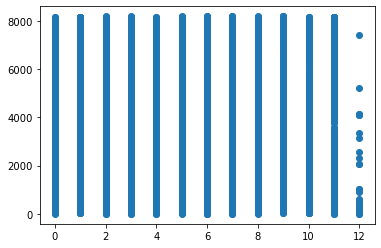

In [10]:
xpol = []
ypol = []
for key, value in policy.items():
    xpol += [value]
    ypol += [key]
plt.scatter(xpol,ypol)

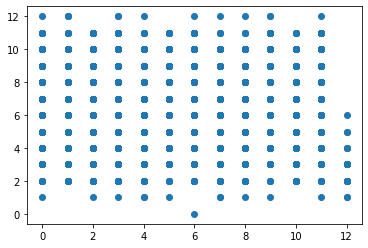

In [11]:
xpol = []
ypol = []
for key, value in policy.items():
    xpol += [value]
    ypol += ["{0:b}".format(key).count("1")]
plt.scatter(xpol,ypol)

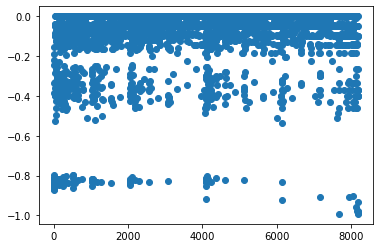

In [12]:
xQ = []
yQ = []
for key, value in Q_sarsa.items():
    xQ += [key]
    yQ += [max(value)]
plt.scatter(xQ,yQ)

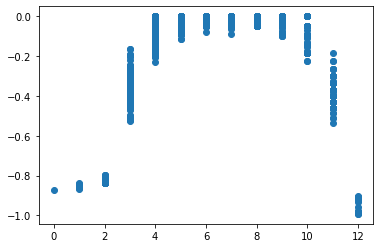

In [13]:
xQ = []
yQ = []
for key, value in Q_sarsa.items():
    xQ += ["{0:b}".format(key).count("1")]
    yQ += [max(value)]
plt.scatter(xQ,yQ)

In [14]:
# example of step action log, reward for all steps are 0 except for the end, of which due to the loss is -1
g = game()
g.reset()
while not g.gameOver():
    g.step()
    g.debug()
    print("")

step count 1
aHand defaultdict(<class 'int'>, {1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 2, 9: 1, 10: 1, 11: 0, 12: 1, 13: 0})
cHand defaultdict(<class 'int'>, {1: 0, 2: 2, 3: 1, 4: 2, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 0})
deck remaining 36
book defaultdict(<class 'int'>, {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0})
score [0, 0]

step count 2
aHand defaultdict(<class 'int'>, {1: 1, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 2, 9: 1, 10: 1, 11: 0, 12: 1, 13: 0})
cHand defaultdict(<class 'int'>, {1: 1, 2: 2, 3: 0, 4: 2, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 0})
deck remaining 35
book defaultdict(<class 'int'>, {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0})
score [0, 0]

step count 3
aHand defaultdict(<class 'int'>, {1: 1, 2: 0, 3: 1, 4: 3, 5: 0, 6: 2, 7: 0, 8: 2, 9: 1, 10: 1, 11: 0, 12: 1, 13: 0})
cHand defaultdict(<class 'int'>, {1: 1, 2: 2, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0

In [15]:
def compress(list):
    c = []
    for i in range(0,len(list),10):
        c += [np.average(list[i:i+10])]
    return c

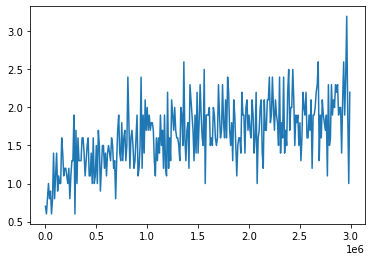

In [16]:
xscore = [i for i,j in scores[1::10]]
yscore = [j for i,j in scores]
plt.plot(xscore,compress(yscore))
#plt.xscale('log',basex=10)

In [17]:
f = open("policyTD.csv", "w")
w = csv.writer(f)
for key, val in policy.items():
    w.writerow([key, val])
f.close()

In [18]:
f = open("QTD.csv", "w")
w = csv.writer(f)
for key, val in Q_sarsa.items():
    w.writerow([key, val])
f.close()

In [19]:
f = open("scoreTD.csv", "w")
w = csv.writer(f)
for x in scores:
    w.writerow([x[0], x[1]])
f.close()